### Using spaCy 's built in dependencies, we can create "syntactically" correct sentences based on different templates.
- These templates are created to be short, in order to fit on an image and be considered "a meme"


In [1]:
import spacy
import pandas as pd
from pprint import pprint
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
import random
import matplotlib.pyplot as plt

pd.set_option('max_colwidth', 120)
import warnings
warnings.filterwarnings('ignore')

For SpaCy:
- instantiate a doc with a variable = nlp()
- then we can use the tokens to: traverse the dependency tree, get parts of speech, entities, dependency labels etc.
- use random to select from a list (non-unique values) or from the keys of a counter class, if needed

Importing the tweets and cleaning them - with regex expressions or not, then keep only the text field

In [3]:
tw = pd.read_csv("tweets_trump1.csv", low_memory = False)
tw = tw[tw["screen_name"] == "realDonaldTrump"]
tweets = tw[["screen_name", "text"]]
tweets["text"] = tweets["text"].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
tweets["text"] = tweets["text"].replace(r'https?:\/\/.*[\r\n]*', '', regex=True).replace(r'www\S+', '', regex=True)
tweets["text"] = tweets["text"].replace(r'RT @\S+:', '', regex = True)
tweets["text"] = tweets["text"].replace(r'[_"\-;%()|.,+&=*%]', '', regex = True)
tweets["text"] = tweets["text"].replace(r'@\s+', '', regex=True)
tweets["text"] = tweets["text"].replace(r'@\S+', '', regex=True)
tweets["text"] = tweets["text"].replace(r'&amp', 'and', regex=True)
tweets["text"] = tweets["text"].str.replace(".@", "@")
tweets["text"] = tweets["text"].replace(r'\n','', regex=True)
tweets["text"] = tweets["text"].str.replace("w/", "with")
tweets["text"] = tweets["text"].str.replace("- ", "")
tweets["text"] = tweets["text"].str.replace("--", "")
tweets["text"] = tweets["text"].str.replace("RE:", "")
tweets["text"] = tweets["text"].str.replace('(&amp)', '')
#tweets["text"] = tweets["text"].str.replace(r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", "")
tweets["text"] = tweets["text"].replace('\n', ' ').replace('\r', '')

In [4]:
tweets1 = tweets["text"]

In [5]:
# tweets shape of the column
tweets1.shape

(32807,)

In [66]:
#tweets[:12]

In [7]:
# transform the tweets to strings to be read by spaCy
tweets2 = tweets1.to_string(header=False, index=False)
tweets2 = tweets2.replace('\n', ' ').replace('\r', '').strip()

visualize with displacy how the dependencies look on a sample

In [8]:
doc =  nlp(tweets1.sample().values[0])
doc

  going to watching Canadian Open this week?Maybe few tour players will visit Trump Toronto!  Great!

In [9]:
displacy.render(doc, style="dep", jupyter=True, options={'distance': 90})

In [10]:
# split the tweets since the spaCy parser cannot work on a huge corpus
tweets3 = tweets2[0:1000000]
doc = nlp(tweets3)
doc1 = nlp(tweets2[1000000:2000000])
doc2 = nlp(tweets2[2000000:3000000])
doc3 = nlp(tweets2[3000000:4000000])

# list of docs
docs = [doc, doc1, doc2, doc3]

### analyze the words in the tweets
- which words occur more often - using TF/IDF
- which named entities are in detected by spaCy (NER)
- which verbs appear most frequently /in their lemma form)
- which adjectives appear most frequently
etc.

- Named Entity Recognition doesn't perform well because of the data

In [11]:
ners = Counter()
def get_ner(corpus, collection):
    for ent in corpus.ents:
        ners[ent.text, ent.label_] +=1
        
for i in docs:
    get_ner(i, ners)
    
ner = ners.most_common(20)
ner
    

[((' ', 'NORP'), 4532),
 (('Obama', 'PERSON'), 930),
 ((' ', 'ORG'), 826),
 (('Donald Trump', 'PERSON'), 793),
 (('America', 'GPE'), 636),
 (('US', 'GPE'), 616),
 (('today', 'DATE'), 569),
 (('China', 'GPE'), 459),
 (('tonight', 'TIME'), 449),
 (('2016', 'DATE'), 387),
 (('Trump2016', 'MONEY'), 365),
 (('American', 'NORP'), 357),
 (('one', 'CARDINAL'), 330),
 (('Donald', 'PERSON'), 307),
 (('Hillary', 'PERSON'), 290),
 (('first', 'ORDINAL'), 289),
 (('ObamaCare', 'ORG'), 280),
 (('           ', 'GPE'), 263),
 (('                       ', 'GPE'), 251),
 (('  ', 'ORG'), 248)]

In [12]:
# get verbs following a subject
# Finding a verb with a subject from below — good
verbs = set()
for possible_subject in doc:
    if possible_subject.dep_ == 'nsubj' and possible_subject.head.pos_ == 'VERB':
        verbs.add(possible_subject.head.lemma_)
#print(verbs)

In [67]:
# get adjectives and nouns
def get_adj_noun(corpus, collection):
    for token in corpus:
        try:
            if token.pos_ == "ADJ":
                if corpus[token.i +1].pos_ == "NOUN":
                    collection.append([str(token), str(corpus[token.i+1])])
        except IndexError:
            pass
                
adj_nouns = list()
for i in docs:
    get_adj_noun(i, adj_nouns)
    
#print(adj_nouns)

In [68]:
#try out some examples
r = random.choice(adj_nouns)
s = "I am an expert in "
s += r[0]
s += " "
s += r[1]
s += ". - Donald (the bot) Trump"

#print(s)

### test with nltk - commented out
from string import punctuation
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download("stopwords")
from sklearn.feature_extraction.text import TfidfVectorizer

stop_words = stopwords.words("english") + list(punctuation)

c = Counter()
def tokenize(text):
    words = word_tokenize(text)
    words = [w.lower() for w in words]
    w =  (w for w in words if w not in stop_words and not w.isdigit())
    c[w] +=1

Most common Gerund verbs

In [69]:
ger = Counter()

def get_top_gerunds(corpus, collection):
    for token in corpus:
        if token.tag_ == "VBD":
            collection[str(token.text).lower()] +=1
            
for i in docs:
    get_top_gerunds(i, ger)
    
#print(ger)

### Template 0 - veni, vidi vici type of thing - example only

In [18]:
g = random.choice(list(ger.keys()))
g1 = random.choice(list(ger.keys()))
g2 = random.choice(list(ger.keys()))
s1 = "I have "
s1 += str(g).lower()
s1 += ", "
s1 += str(g1).lower()
s1 += " and "
s1 += str(g2).lower()
s1 += " without being scared. -Donald (the bot) Trump"

print(s1)

I have rigged, dispensed and profited without being scared. -Donald (the bot) Trump


Most common lemmatized verbs

In [19]:
c = Counter()

def get_top_verbs(corpus, collection):
    for token in corpus:
        if token.tag_ in ["VB", "VBG", "VBP", "VBD", "VBN", "VBZ"]:
            collection[str(token.lemma_).lower()] +=1
           
for i in docs:
    get_top_verbs(i, c) 

Plot the most common verbs (lemmatized form)

<BarContainer object of 20 artists>

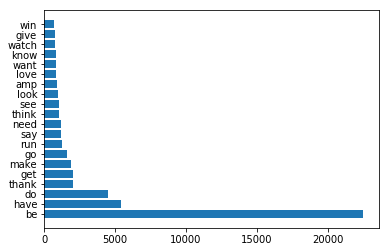

In [21]:
a = c.most_common(20)
a = pd.DataFrame(a, columns = ["word", "frequency"])
plt.barh(a["word"], a["frequency"])

Random example

x = random.choice(list(c.keys()))
x1 = random.choice(list(c.keys()))
s = "You can't make me "
s += str(x).lower()
#s += " what you "
#s += str(x1).lower()
s += ". - Donald (the bot) Trump"

print(s)

Most common nouns appearing after "be a"

In [23]:
c2 = Counter()
def get_words_after_is(corpus, collection):
    for token in corpus:
        try:
            if token.text == "is" and corpus[token.i+1].text == "a":
                if corpus[token.i +2].tag_ == "NN" and corpus[token.i+2].pos:
                    collection[str(corpus[token.i +2]).lower()] += 1
        except IndexError:
            pass
        
for i in docs:
    get_words_after_is(i, c2)

<BarContainer object of 20 artists>

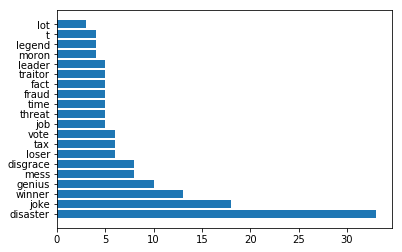

In [70]:
# plot the most common nouns appearing after IS (BE)
a = c2.most_common(20)
a = pd.DataFrame(a, columns = ["word", "frequency"])
plt.barh(a["word"], a["frequency"])


Get top nouns in singulas and plural

In [26]:
c1 = Counter()

def get_top_nouns(corpus, collection):
    for token in corpus:
        if token.tag_ in ["NN", "NNS"]:
            c1[str(token.text).lower()] +=1

In [27]:
# run the function
for i in docs:
    get_top_nouns(i, c1)
c1.most_common(10)

[('thanks', 1773),
 ('amp', 1567),
 ('#', 1445),
 ('people', 1399),
 ('country', 961),
 ('time', 927),
 ('president', 862),
 ('today', 777),
 ('tonight', 617),
 ('job', 539)]

Try noun_chunks

In [28]:
nc = set()
def get_noun_chunks(doc, collection):
    for np in doc.noun_chunks:
        collection.add(np.text)

In [29]:
get_noun_chunks(doc, nc)
#print(nc)

### Functions

In [133]:
def get_dependencies(doc, collection, dep1 = None, dep2 = None, dep3 = None):
    """get the dependencies (up to 3) and store them in separate collections as lists
    dependencies available are (examples): dobj, nsubj, csubj, aux, neg, ROOT, det, quantmod etc."""
    try:
        if dep2 == None:
            for token in doc:
                if token.dep_ == dep1:
                    collection.append([str(token.text)])

        elif dep3 == None:
            for token in doc:
                if token.dep_ == dep1:
                    if doc[token.i +1].dep_ == dep2:
                        collection.append([str(token.text), str(doc[token.i+1].lemma_)])
        else:
            for token in doc:
                if token.dep_ == dep1:
                    if doc[token.i +1].dep_ == dep2 and doc[token.i +2].dep_ == dep3:
                        collection.append([str(token.text), str(doc[token.i+1].text), str(doc[token.i+2].text)])
    except IndexError:
        pass

In [134]:
def get_tags(doc, collection, tag1, tag2):
    """get 2 tags in the documents"""
    for tag in doc:
        if tag.tag_ == "tag1":
            if doc[tag.i + 1].tag_ == "tag2":
                collection.add([str(tag), str(doc[tag.i+1])])

In [135]:
def get_dependencies_lemmatized(doc, collection, dep1 = None, dep2 = None, dep3 = None):
    """get the dependencies (up to 3) and store them in separate collections as lists
    dependencies available are (examples): dobj, nsubj, csubj, aux, neg, ROOT, det, quantmod etc."""
    try:
        if dep2 == None:
            for token in doc:
                if token.dep_ == dep1:
                    collection.append([str(token.text), str(doc[token.i+1])])

        elif dep3 == None:
            for token in doc:
                if token.dep_ == dep1:
                    if doc[token.i +1].dep_ == dep2:
                        collection.append([str(token.text), str(doc[token.i+1].lemma_)])
        else:
            for token in doc:
                if token.dep_ == dep1:
                    if doc[token.i +1].dep_ == dep2 and doc[token.i +2].dep_ == dep3:
                        collection.append([str(token.lemma_), str(doc[token.i+1]), str(doc[token.i+2])])
    except IndexError:
        pass

In [136]:
def deps_printout(sentence):
    """Prints out the text, tag, dep, head text, head tag, token lemma and part 
    of speech for each word in a sentence"""
                  
    doc1 = nlp(sentence)

    for token in doc1:
        print("{0}/{1} <--{2}-- {3}/{4} {5} {6}".format(
            token.text, token.tag_, token.dep_, token.head.text, token.head.tag_, token.lemma_, token.pos_))

### Templates:
- In order to get a sense of what we need, there is a function that simply displays the dependency tree: 

In [137]:
deps_printout("The beauty of me is that I am very rich.")

The/DT <--det-- beauty/NN the DET
beauty/NN <--nsubj-- is/VBZ beauty NOUN
of/IN <--prep-- beauty/NN of ADP
me/PRP <--pobj-- of/IN -PRON- PRON
is/VBZ <--ROOT-- is/VBZ be VERB
that/IN <--mark-- am/VBP that ADP
I/PRP <--nsubj-- am/VBP -PRON- PRON
am/VBP <--ccomp-- is/VBZ be VERB
very/RB <--advmod-- rich/JJ very ADV
rich/JJ <--acomp-- am/VBP rich ADJ
./. <--punct-- is/VBZ . PUNCT


Template 1

In [138]:
# get dependencies for the template You should never try To
def get_ngrams_for_template1():
    adv_acomp = []
    for i in docs:
        for i in docs:
            get_dependencies(i, adv_acomp, dep1 = "advmod", dep2 = 'acomp')
    return adv_acomp

t1_src = get_ngrams_for_template1()

def template1(source):
    # complete the sentence and return it
    a1 = random.choice(source)
    temp1 = "The beauty of me is that I am " + " ".join([x for x in a1])
    temp1 += ". - Donald (the bot) Trump"
    return temp1

In [140]:
template1(t1_src)

'The beauty of me is that I am very bad. - Donald (the bot) Trump'

Template 2

In [141]:
def get_ngrams_for_template2():
    # Get ROOT + AMOD + DOBJ IN THE FORM OF VERB + ADJ + NOUN
    van = []

    for i in docs:
        for token in i:
            if token.dep_ == "amod" and token.pos_ == "ADJ":
                if i[token.i + 1].dep_ == "dobj" and i[token.i+1].pos_ == "NOUN" and i[token.i+1].tag_ == "NN" \
                    and i[token.i+2].dep_ == "punct":
                    van.append([str(token.text).lower(), str(i[token.i+1].text).lower()])
    return van
    
t2_src = get_ngrams_for_template2()

def template2(source):
    v = random.choice(source)
    start = "Is there such a thing as an "
    start1 = "Is there such a thing as "
    start2 = "Is there such a thing as a "
    end = "? - Donald (the bot) Trump"
    if len(v[1]) <=2:
        pass
    elif v[0][0] in["a", "e", "i", "o", "u"]:
        temp2 = start + " ".join([x for x in v]) + end
    elif v[0] == "great":
        temp2 = start1 + " ".join([x for x in v]) + end
    else:
        temp2 = start2 + " ".join([x for x in v]) + end
    return temp2

In [142]:
template2(t2_src)

'Is there such a thing as great compliment? - Donald (the bot) Trump'

Template 3

In [143]:
# show the dependencies in the sample
deps_printout("My Twitter has become so powerful that I can actually make my enemies tell the truth.")

My/PRP$ <--poss-- Twitter/NN -PRON- ADJ
Twitter/NN <--nsubj-- become/VBN twitter NOUN
has/VBZ <--aux-- become/VBN have VERB
become/VBN <--ROOT-- become/VBN become VERB
so/RB <--advmod-- powerful/JJ so ADV
powerful/JJ <--acomp-- become/VBN powerful ADJ
that/IN <--mark-- make/VB that ADP
I/PRP <--nsubj-- make/VB -PRON- PRON
can/MD <--aux-- make/VB can VERB
actually/RB <--advmod-- make/VB actually ADV
make/VB <--ccomp-- powerful/JJ make VERB
my/PRP$ <--poss-- enemies/NNS -PRON- ADJ
enemies/NNS <--nsubj-- tell/VB enemy NOUN
tell/VB <--ccomp-- make/VB tell VERB
the/DT <--det-- truth/NN the DET
truth/NN <--dobj-- tell/VB truth NOUN
./. <--punct-- become/VBN . PUNCT


In [146]:
def get_ngrams_for_template3():
    det_d = []
    for i in docs:
        get_dependencies_lemmatized(i, det_d, dep1 = "ccomp", dep2 = 'det', dep3 = "dobj")
        
    return det_d

t3_src = get_ngrams_for_template3()

def template3(source1, source2):
    a2 = random.choice(source1)
    a3 = random.choice(source2)
    
    t = "My Twitter has become an "
    t_1 = "My Twitter has become a "
    mid = ", I can actually make my enemies "
    end = ". - Donald (the bot) Trump"
    
    if len(a3[0]) <= 2:
        pass
    elif a3[0][0] in ["a", "e", "i", "o", "u"]:
        #a = (*a3, sep=" ")
        temp3 = t + " ".join([x for x in a3]) + mid + " ".join([x for x in a2]) + end
    else:
        temp3 = t_1 + " ".join([x for x in a3]) + mid + " ".join([x for x in a2]) + end
    return temp3

    


In [147]:
template3(t3_src, t2_src)

'My Twitter has become a terrific weekend, I can actually make my enemies land another billionaire. - Donald (the bot) Trump'

Templates 4, 5 and 6

In [157]:
# see how the text looks like in dependencies
deps_printout("I think the only difference between me and the other candidates "
              "is that I'm more beautiful and more attentive.")

I/PRP <--nsubj-- think/VBP -PRON- PRON
think/VBP <--ROOT-- think/VBP think VERB
the/DT <--det-- difference/NN the DET
only/JJ <--amod-- difference/NN only ADJ
difference/NN <--nsubj-- is/VBZ difference NOUN
between/IN <--prep-- difference/NN between ADP
me/PRP <--pobj-- between/IN -PRON- PRON
and/CC <--cc-- me/PRP and CCONJ
the/DT <--det-- candidates/NNS the DET
other/JJ <--amod-- candidates/NNS other ADJ
candidates/NNS <--conj-- me/PRP candidate NOUN
is/VBZ <--ccomp-- think/VBP be VERB
that/IN <--mark-- 'm/VBP that ADP
I/PRP <--nsubj-- 'm/VBP -PRON- PRON
'm/VBP <--ccomp-- is/VBZ be VERB
more/RBR <--advmod-- beautiful/JJ more ADV
beautiful/JJ <--acomp-- 'm/VBP beautiful ADJ
and/CC <--cc-- beautiful/JJ and CCONJ
more/RBR <--advmod-- attentive/JJ more ADV
attentive/JJ <--conj-- beautiful/JJ attentive ADJ
./. <--punct-- think/VBP . PUNCT


In [158]:
# see how the text looks like in dependencies
deps_printout("I think the only difference between me and the other candidates "
              "is that I'm better and cheaper.")

I/PRP <--nsubj-- think/VBP -PRON- PRON
think/VBP <--ROOT-- think/VBP think VERB
the/DT <--det-- difference/NN the DET
only/JJ <--amod-- difference/NN only ADJ
difference/NN <--nsubj-- is/VBZ difference NOUN
between/IN <--prep-- difference/NN between ADP
me/PRP <--pobj-- between/IN -PRON- PRON
and/CC <--cc-- me/PRP and CCONJ
the/DT <--det-- candidates/NNS the DET
other/JJ <--amod-- candidates/NNS other ADJ
candidates/NNS <--conj-- me/PRP candidate NOUN
is/VBZ <--ccomp-- think/VBP be VERB
that/IN <--mark-- 'm/VBP that ADP
I/PRP <--nsubj-- 'm/VBP -PRON- PRON
'm/VBP <--ccomp-- is/VBZ be VERB
better/JJR <--acomp-- 'm/VBP good ADJ
and/CC <--cc-- better/JJR and CCONJ
cheaper/JJR <--conj-- better/JJR cheap ADJ
./. <--punct-- think/VBP . PUNCT


In [250]:
def get_ngrams_for_template4():
    jjr = []
    for i in docs:
        for token in i:
            if token.dep_ == "ccomp" and token.tag_ == "VBP":
                if i[token.i+1].tag_ == "JJR" and i[token.i+1].text != "more":
                    jjr.append(str(i[token.i+1]).lower())
    jjs = []
    for i in docs:
        for token in i:
            if token.dep_ == "det":
                if i[token.i+1].tag_ == "JJS" and i[token.i+1].text != "most":
                    jjs.append(str(i[token.i+1]).lower())
    jj = []
    for i in docs:
        for token in i:
            if token.dep_ == "advmod" and token.tag_ == "RBR":
                if i[token.i+1].tag_ == "JJ" and i[token.i+1].text != "more":
                    jj.append(str(i[token.i+1]).lower())
    jj1 = set(jj)
    jj = list(jj1)
    
    jjr1 = set(jjr)
    jjr1.remove("less")
    jjr = list(jjr1)
    
    jjs1 = set(jjs)
    jjs = list(jjs1)
    return jj, jjr, jjs

t4_src, t5_src, t6_src = get_ngrams_for_template4()

def template4(source):
    
    jj = random.choice(source)
    jj1 = random.choice(source)
    
    
    start = "I think the only difference between me and other candidates is that I'm more "
    mid = " and more "
    end = ". - Donald (the bot) Trump"
    
    temp4 = start + jj + mid + jj1 + end
    return temp4


def template5(source):
    jjr = random.choice(source)
    jjr1 = random.choice(source)
    
    start = "I think the only difference between me and other candidates is that I'm "
    mid = " and "
    end = ". - Donald (the bot) Trump"
    
    temp5 = start + jjr + mid + jjr1 + end
    return temp5

def template6(source):
    jjs = random.choice(source)
    start = "I am NOT a shmuck. I am the "
    end = " there is. - Donald (the bot) Trump"
    
    temp6 = start + jjs + end
    return temp6

In [251]:
template4(t4_src)

"I think the only difference between me and other candidates is that I'm more interested and more serious. - Donald (the bot) Trump"

In [252]:
template5(t5_src)

"I think the only difference between me and other candidates is that I'm funnier and smarter. - Donald (the bot) Trump"

In [253]:
template6(t6_src)

'I am NOT a shmuck. I am the secondhighest there is. - Donald (the bot) Trump'

Template 7

In [257]:
def get_ngrams_for_temp7():
    obj = []
    for i in docs:
        get_dependencies(i, obj, dep1 = "det", dep2 = "dobj")
    return obj

t7_src = get_ngrams_for_temp7()

def template7(source):
    
    o = random.choice(source)
    
    start = "I would say I'm the all-time judge of "
    end = ". - Donald (the bot) Trump"
    
    temp7 = start + " ".join([x for x in o]) + end
    return temp7

In [258]:
template7(t7_src)

"I would say I'm the all-time judge of an attack. - Donald (the bot) Trump"

## FINAL FUNCTION - randomizez the template

In [262]:
functions = [template1(t1_src), template2(t2_src), template3(t3_src, t2_src), 
             template4(t4_src), template5(t5_src), template6(t6_src), template7(t7_src)]

In [263]:
def temp_output(funcs):
    """choose at random from a list of the template functions"""
    f = random.choice(funcs)
    return f
    

In [264]:
temp_output(functions)

'Is there such a thing as a fair shake? - Donald (the bot) Trump'